# Using PLAYA-PDF to extract document outlines

PDFs commonly contain a "document outline" which is a machine-readable table of contents, usually presented in a sidebar by PDF readers.  Here, we will extract this outline and format it as HTML.

First, obviously, we must import the `playa` module:

In [1]:
import playa

Now, let's open [a PDF](../samples/contrib/stochastic_parrots.pdf), in this case, the classic paper "On the Dangers of Stochastic Parrots" (Bender, Gebru, McMillan-Major, Mitchell, 2021, https://doi.org/10.1145/3442188.3445922):

In [2]:
DOCUMENT = "../samples/contrib/stochastic_parrots.pdf"
pdf = playa.open(DOCUMENT)

## TL;DR if you are lazy: use the eager API to get an object

If you just want to grab some metadata and spit it out as JSON or whatever, `playa.asobj` will generally do something useful for you.  This is as simple as you would expect:

In [3]:
playa.asobj(pdf.outline)

[{'title': 'Abstract',
  'destination': {'page_idx': 1,
   'display': 'XYZ',
   'coords': [53.798, 546.17, None]}},
 {'title': '1 Introduction',
  'destination': {'page_idx': 1,
   'display': 'XYZ',
   'coords': [53.798, 227.588, None]}},
 {'title': '2 Background',
  'destination': {'page_idx': 2,
   'display': 'XYZ',
   'coords': [53.798, 492.73, None]}},
 {'title': '3 Environmental and Financial Cost',
  'destination': {'page_idx': 3,
   'display': 'XYZ',
   'coords': [53.798, 321.421, None]}},
 {'title': '4 Unfathomable Training Data',
  'destination': {'page_idx': 4,
   'display': 'XYZ',
   'coords': [53.798, 423.907, None]},
  'children': [{'title': "4.1 Size Doesn't Guarantee Diversity",
    'destination': {'page_idx': 4,
     'display': 'XYZ',
     'coords': [53.798, 278.407, None]}},
   {'title': '4.2 Static Data/Changing Social Views',
    'destination': {'page_idx': 5,
     'display': 'XYZ',
     'coords': [53.798, 334.076, None]}},
   {'title': '4.3 Encoding Bias',
    'dest

## Let's format a tree as HTML

We could also use [ipytree]() but it won't display nicely with `nbconvert` in GitHub, so bare HTML it is!

Here we'll use the "lazy" API to descend into the outline, which is represented by a `playa.outline.Tree` object that is of type `Iterable[playa.outline.Item]`.

In [4]:
from IPython.display import HTML
from itertools import chain

def make_item(outline):
    return outline.title

def make_list(outline):
    html = ["<li>"]
    html.append(make_item(outline))
    items = list(outline)
    if items:
        html.append("<ul>")
        for item in items:
            html.extend(make_list(item))
        html.append("</ul>")
    html.append("</li>")
    return html

def make_html(outline):
    return "\n".join(["<ul>", *chain.from_iterable(make_list(outline) for outline in pdf.outline), "</ul>"])

HTML(make_html(pdf.outline))

## Let's add links to the pages in the PDF from the outline

Obviously, just getting the titles of the outline items isn't incredibly useful, though it's a start.  As you might expect, these items refer to actual locations in the document (they can also be associated with other interactive actions, though I have no idea why that is useful).

We can't display the PDF interactively here in this notebook (at least not without a custom widget), but we can link to pages using the `#page=N` convention supported by browsers.  To do this, we use the `destination` property of the outline items.  Note that we index pages from zero in PLAYA:

In [5]:
def make_item(outline):
    return f'<a href="{DOCUMENT}#page={outline.destination.page_idx + 1}">{outline.title}</a>'

HTML(make_html(pdf.outline))

## Let's look at the outline destinations

We can, of course, also get text out of PDFs.  Like all things, this works better when people make tagged and/or accessible PDFs, so please do that, but it also works for ordinary ones like this one.

For instance we can get all the text from a destination page, but again, this isn't super useful:

In [6]:
def make_item(item):
    return f"<b>{item.title}</b>: {item.destination.page.extract_text()[:80]}"

HTML(make_html(pdf.outline))

So, let's get the text near the destination position.  What is the position?  Well, it could be many things (see PDF 2.0 section 12.3.2) but fundamentally it's a `display` method and a position that goes with it.  In this case we have `playa.outline.DISPLAY_XYZ` as the method, which means "an x, y position plus an optional zoom level".

There are a variety of properties defined on a destination which are always guaranteed to be valid, even if the underlying information is not present in the PDF - so for instance, the position will simply default to the top-left corner of the page if unspecified.  Here we can use `bbox` to get a bounding box which includes the destination - by default this will extend to the right edge and bottom of the page, which is exactly what we want in order to extract text at or after the destination:

In [7]:
def make_item(item):
    dest = item.destination
    return f"<b>{item.title}</b>: {dest.display.name} @ {dest.bbox}"

HTML(make_html(pdf.outline))

We can, for instance, get an image of the destination using [PAVÉS](https://github.com/dhdaines/paves) and Pillow:


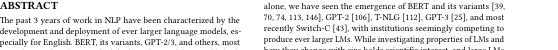
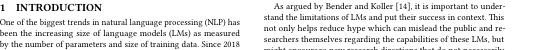
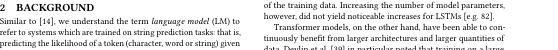
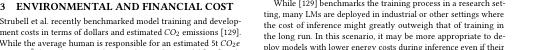
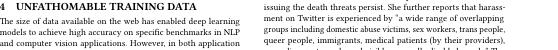
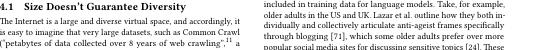
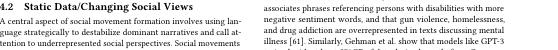
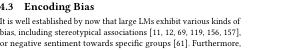
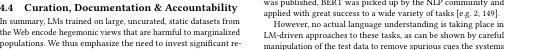
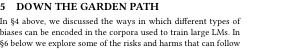
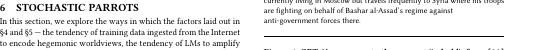
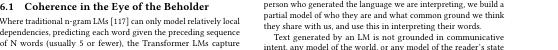
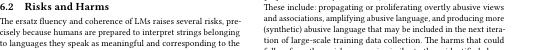
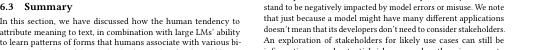
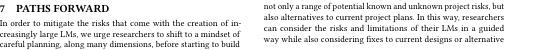
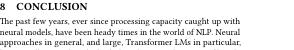
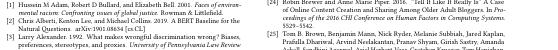

In [8]:
import paves.image as pi
import base64
from io import BytesIO

def dataurl(img):
    with BytesIO() as fh:
        img.save(fh, format="JPEG")
        return f"data:image/jpeg;base64,{base64.b64encode(fh.getvalue()).decode('ascii')}"

def make_item(item):
    dest = item.destination
    left, top, right, bottom = dest.bbox
    bottom = top + 50
    img = pi.show(dest.page).crop((left, top, right, bottom))
    return f"<b>{item.title}</b>: {dest.display.name} @ {dest.bbox}<br><img src='{dataurl(img)}'>"

HTML(make_html(pdf.outline))

That's cool, but what if we want actual, machine-readable text?  **NO**, the answer is not "feed these images to `$HUGE_VLM_OR_OCR_MODEL`"! Since extracting text at a location on a page is an incredibly common use case, `extract_text` has us covered here:

In [9]:
def make_item(item):
    dest = item.destination
    return f"<b>{item.title}</b>: {dest.page.extract_text(bbox=dest.bbox)[0:100]}"

HTML(make_html(pdf.outline))

# 